# Modular Text Summarization

## Introduction
In the age of information overload, automatic summarization has become crucial for extracting essential information from long text data. Dialogue summarization, a subdomain of text summarization, focuses on condensing multi-turn conversations (like chat or meeting transcripts) into concise summaries that retain the key points. This task is challenging due to the informal and unstructured nature of dialogues compared to regular text.

In this project, we leverage the power of pretrained transformer-based models — specifically the BART model (facebook/bart-large-cnn) — to generate abstractive summaries from dialogue datasets. The model is fine-tuned for summarization tasks and excels at understanding context and generating human-like summaries.

## Objective
The main objectives of this project are:
*   To implement a complete pipeline for abstractive dialogue summarization using Hugging Face's Transformers.
*   To load and preprocess the dialogue dataset using datasets library.
*   To utilize the pretrained facebook/bart-large-cnn model for generating summaries.
*   To evaluate the performance of the summarization using ROUGE metrics.
*   To analyze and compare the generated summaries with reference summaries for quality assessment.

## Dataset Description
We use the Samsum Dataset, a benchmark dataset for dialogue summarization. It contains thousands of English language conversations along with professionally written abstractive summaries.
The SAMSum dataset contains informal, real-life chat-style conversations, often short but contextually rich.Many conversations have abrupt topic shifts, emojis, or casual tone  making summarization non-trivial.The dataset supports quick experimentation due to its small size, but is still diverse enough to test generalization capabilities.

*   Dataset Name: samsum
*   Source: Hugging Face Datasets Library
*   Split:Train : 14,000 examples, Validation: 800 examples, Test: 800 examples

*   Fields: dialogue A multi-turn conversation between two people and a human-written summary of the dialogue.

Link to Dataset - https://huggingface.co/datasets/Samsung/samsum

## Model Used: facebook/bart-large-cnn



*   Model Type: BART – Bidirectional and Auto-Regressive Transformers.
*   Architecture: Sequence-to-sequence model with a transformer-based encoder and decoder.
*   Pretrained On: Large-scale corpus (e.g., news articles, Wikipedia).
*   Fine-Tuned For: Abstractive text summarization on the CNN/DailyMail dataset.
*   Tokenizer: Uses AutoTokenizer from Hugging Face Transformers – handles tokenization, padding, truncation.
*   Summarization Approach: Generates summaries using beam search or greedy decoding strategies.

Link to Model on Hugging Face: - https://huggingface.co/facebook/bart-large-cnn






In [ ]:
!pip install py7zr
!pip install transformers datasets rouge-score

In [1]:
%%writefile data_loader.py
from datasets import load_dataset

class DataLoader:
    def __init__(self, dataset_name='samsum'):
        self.dataset = load_dataset(dataset_name)

    def get_data(self, split='test'):
        return self.dataset[split]

Writing data_loader.py


In [3]:
%%writefile model.py
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

class SummarizationModel:
    def __init__(self, model_name):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

    def summarize(self, text, max_length=150, min_length=40, do_sample=False):
        inputs = self.tokenizer(
            [text],
            return_tensors="pt",
            truncation=True,
            padding="longest",
            max_length=1024
        )
        summary_ids = self.model.generate(
            inputs["input_ids"],
            max_length=max_length,
            min_length=min_length,
            do_sample=do_sample,
            num_beams=4,
            length_penalty=2.0,
            early_stopping=True
        )
        return self.tokenizer.decode(summary_ids[0], skip_special_tokens=True).strip()


Writing model.py


In [4]:
%%writefile pipeline.py
class SummarizationPipeline:
    def __init__(self, data_loader, model):
        self.data_loader = data_loader
        self.model = model

    def run(self, num_samples=5):
        data = self.data_loader.get_data()
        results = []

        for idx, item in enumerate(data.select(range(num_samples))):
            dialogue = item['dialogue']
            reference = item['summary']
            generated = self.model.summarize(dialogue)
            results.append({
                "dialogue": dialogue,
                "reference": reference,
                "generated": generated
            })
        return results


Writing pipeline.py


In [5]:
%%writefile evaluator.py
from rouge_score import rouge_scorer

class Evaluator:
    def __init__(self):
        self.scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    def evaluate(self, results):
        scores = {"rouge1": [], "rouge2": [], "rougeL": []}
        for item in results:
            ref = item['reference']
            gen = item['generated']
            score = self.scorer.score(ref, gen)
            for k in scores:
                scores[k].append(score[k].fmeasure)
        avg_scores = {k: sum(v)/len(v) for k, v in scores.items()}
        return avg_scores


Writing evaluator.py


In [9]:
# main.py
from data_loader import DataLoader
from model import SummarizationModel
from pipeline import SummarizationPipeline
from evaluator import Evaluator

def main():
    loader = DataLoader()
    model = SummarizationModel(model_name="facebook/bart-large-cnn")
    pipeline = SummarizationPipeline(loader, model)

    results = pipeline.run(num_samples=3)

    evaluator = Evaluator()
    scores = evaluator.evaluate(results)

    for i, item in enumerate(results):
        print(f"\nExample {i + 1}")
        print("Dialogue:", item["dialogue"])
        print("Reference:", item["reference"])
        print("Generated:", item["generated"])
        print("-" * 80)

    print("\nROUGE Scores:")
    for k, v in scores.items():
        print(f"{k}: {v:.4f}")

if __name__ == "__main__":
    main()



Example 1
Dialogue: Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye
Reference: Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.
Generated: Hannah: Hey, do you have Betty's number? Amanda: Lemme check. Ask Larry. He called her last time we were at the park together. I don't know him well.
--------------------------------------------------------------------------------

Example 2
Dialogue: Eric: MACHINE!
Rob: That's so gr8!
Eric: I know! And shows how Americans see Russian ;)
Rob: And it's really funny!
Eric: I know! I especially like the train part!
Rob: Hahaha! No one talks to the machine like tha

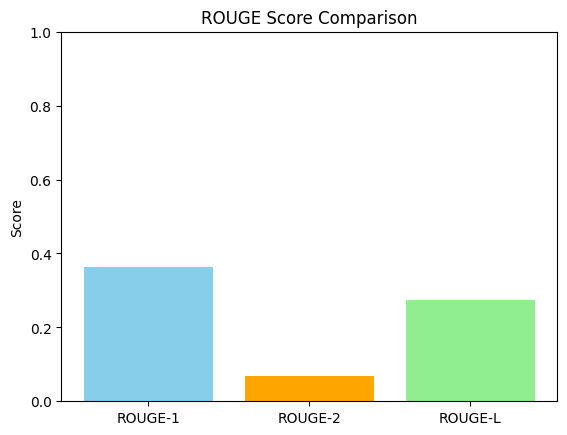

In [10]:
import matplotlib.pyplot as plt
rouge_scores = {'ROUGE-1': 0.363, 'ROUGE-2': 0.069, 'ROUGE-L': 0.274}
plt.bar(rouge_scores.keys(), rouge_scores.values(), color=['skyblue', 'orange', 'lightgreen'])
plt.title('ROUGE Score Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()

## Limitations
*   Model bias: The pretrained BART model may sometimes produce generic or repetitive summaries.
*   No fine-tuning: Since we only used a pretrained model, the results could be improved with fine-tuning on the samsum dataset.
*   Truncation issues: Long dialogues might get truncated at the tokenization stage due to token limits.
*   ROUGE limitations: ROUGE scores may not always reflect true summary quality — especially for paraphrased or semantically correct summaries.

##Improvements
*   Fine-tune BART or T5 specifically on SAMSum for better domain adaptation.
*   Preprocessing: Clean up dialogues — remove filler words, standardize emojis or abbreviations.
*   Try different models: Explore PEGASUS, DistilBART, or Flan-T5 and compare performance.
*   Add visualizations (bar plots of ROUGE scores, word clouds of summaries, etc.) for better insights.







## Conclusion
While the implementation of a text summarization model using the BART architecture performed decently, several improvements can be made by fine-tuning the model, incorporating multimodal information, and exploring new evaluation methods. The limitations of informal language, small datasets, and token restrictions highlight the need for specialized models and domain-specific datasets in the future.